In [1]:
# Imports

from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction as UDF
from pyspark.sql.functions import size, col
from pyspark.sql.types import ArrayType, StringType, IntegerType

In [2]:
# Start session

ss = SparkSession\
        .builder\
        .master("spark://192.168.2.61:7077") \
        .appName("olek")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled", True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout", "30s")\
        .config("spark.driver.port", 9998)\
        .config("spark.blockManager.port", 10005)\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/16 15:02:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/16 15:02:40 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [3]:
# Read file
df = ss.read.json('hdfs://192.168.2.184:9000/RC_2009-10')
df.printSchema()

root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- removal_reason: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [4]:
# Drop unused columns
df = df.drop('archived', 'author', 'author_flair_css_class', 'author_flair_text', 'created_utc', 'edited',\
            'gilded', 'id', 'link_id', 'name', 'parent_id', 'removal_reason', 'retrieved_on',\
            'score_hidden', 'subreddit_id', 'distinguished', 'controversiality');

df.printSchema()

root
 |-- body: string (nullable = true)
 |-- downs: long (nullable = true)
 |-- score: long (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- ups: long (nullable = true)



In [5]:
# Tokenize comment body

import string
def tokenize(text):
    return text.translate(str.maketrans('', '', string.punctuation)).lower().split()

udf_tokenize =  UDF(tokenize, ArrayType(StringType()))

df = df.withColumn('body', udf_tokenize(df.body))

In [6]:
# Comment length feature

df = df.withColumn('comment_length', size(df.body))

In [7]:
# Deleted comment feature
def check_deleted(line):
    if line == ['removed'] or line == ['deleted']:
        return 1
    else:
        return 0

udf_deleted = UDF(check_deleted, IntegerType())

df = df.withColumn('deleted', udf_deleted(df.body))


df.select('deleted').show()

+-------+
|deleted|
+-------+
|      1|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      1|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
+-------+
only showing top 20 rows



In [8]:
# Controversial words feature

cont_words = 'abuse, administration, afghanistan, aid, america,' + \
'american, army, attack, attacks, authorities, authority, ban, banks, benefits, bill, bills,' + \
'border, budget, campaign, candidate, candidates, catholic, china, chinese, church,'+ \
'concerns, congress, conservative, control, country, court, crime, criminal, crisis, cuts,'+\
'debate, debt, defense, deficit, democrats, disease, dollar, drug, drugs, economy, education,'+\
'egypt, election, elections, enforcement, fighting, finance, fiscal, force, funding,'+\
'gas, government, gun, health, immigration, inaccuracies, india, insurance, investigation,'+\
'investigators, iran, israel, job, jobs, judge, justice, killing, korea, labor, land,'+\
'law, lawmakers, laws, lawsuit, leadership, legislation, marriage, media, mexico, military,'+\
'money, murder, nation, nations, news, obama, offensive, officials, oil, parties,'+\
'peace, police, policies, policy, politics, poll, power, president, prices, primary, prison,'+\
'progress, race, reform, republican, republicans, restrictions, rule, rules, ruling, russia,'+\
'russian, school, security, senate, sex, shooting, society, spending, strategy, strike, support,'+\
'syria, syrian, tax, taxes, threat, trial, unemployment, union, usa, victim, victims,'+\
'violence, vote, voters, war, washington, weapons, world,'

semi_cont_words = 'account, advantage, amount, attorney, chairman,'+\
'charge, charges, cities, class, comment, companies, cost, credit, delays, effect, expectations,'+\
'families, family, february, germany, goal, housing, information, investment,'+\
'markets, numbers, oklahoma, parents, patients, population, price, projects, raise, rate,'+\
'reason, sales, schools, sector, shot, source, sources, status, stock, store, worth,'

controversial = tokenize(cont_words)
semi_controversial = tokenize(semi_cont_words)

def controversial_words(line, controversial = controversial, semi_controversial = semi_controversial):
    score = 0
    for word in line:
        if word in controversial:
            score += 3
        elif word in semi_controversial:
            score += 1
    return score
    
udf_controversial = UDF(controversial_words, IntegerType())

df = df.withColumn('cont_word_score', udf_controversial('body'))

In [9]:
df.select('subreddit').show()

+-----------+
|  subreddit|
+-----------+
|       IAmA|
|programming|
| reddit.com|
|   politics|
|       IAmA|
|        WTF|
|       pics|
|       IAmA|
|     gaming|
|  Marijuana|
|       lgbt|
|        tf2|
|       IAmA|
|  worldnews|
|     Health|
|  AskReddit|
|   politics|
|        tf2|
|    toronto|
| reddit.com|
+-----------+
only showing top 20 rows



In [10]:
df.printSchema()

root
 |-- body: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- downs: long (nullable = true)
 |-- score: long (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- ups: long (nullable = true)
 |-- comment_length: integer (nullable = false)
 |-- deleted: integer (nullable = true)
 |-- cont_word_score: integer (nullable = true)



In [11]:
controversial_subreddits = ["Conservative", "syriancivilwar", "conspiracy", "SeattleWA", "ukpolitics", "canada", "DC_cinematics", "worldnews", "bestof", "news", "europe", "Austin", "Documentaries", "PublicFreakout", "Portland", "JusticeServed", "JoeRogan", "toronto", "Games", "vancouver"] 

In [12]:
#check if comment was posted on potentially controversial subreddit
def controversial_subreddits(line, controversial_subreddits = controversial_subreddits):
    if line in controversial_subreddits:
        return 1
    else:
        return 0
    
udf_subreddits = UDF(controversial_subreddits, IntegerType())   
df = df.withColumn('cont_subreddits', udf_controversial(df.subreddit))

In [13]:
#dropping columns we develop features on, just in case changing long ints to ints
df = df.drop("subreddit", "body")
df = df.withColumn('downs',df['downs'].cast("int").alias('downs'))
df = df.withColumn('ups',df['ups'].cast("int").alias('ups'))
df = df.withColumn('score',df['score'].cast("int").alias('score'))

In [14]:
df.printSchema()

root
 |-- downs: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = true)
 |-- comment_length: integer (nullable = false)
 |-- deleted: integer (nullable = true)
 |-- cont_word_score: integer (nullable = true)
 |-- cont_subreddits: integer (nullable = true)



In [15]:
#calculatiog ratio postive class/negative class
positive = df.filter(col("deleted") == 1)
negative = df.filter(col("deleted") == 0)
ratio = positive.count()/negative.count()
print("ratio: {}".format(ratio))

ratio: 0.09017560835665296


In [16]:
#undersampling
sampled_df = negative.sample(False, ratio)
undersampled_df = sampled_df.unionAll(positive)


In [17]:
#checking if undersampling worked
undersampled_df.select("deleted").where(undersampled_df["deleted"] == 1).count()

185452

In [18]:
#checking if undersampling worked
undersampled_df.select("deleted").where(undersampled_df["deleted"] == 0).count()

185600

In [19]:
undersampled_df.show()

+-----+-----+---+--------------+-------+---------------+---------------+
|downs|score|ups|comment_length|deleted|cont_word_score|cont_subreddits|
+-----+-----+---+--------------+-------+---------------+---------------+
|    0|    1|  1|             5|      0|              0|              0|
|    0|    1|  1|            22|      0|              0|              0|
|    0|    1|  1|           201|      0|             18|              0|
|    0|    5|  5|             4|      0|              0|              0|
|    0|   15| 15|             6|      0|              0|              0|
|    0|    0|  0|            12|      0|              3|              0|
|    0|    3|  3|             5|      0|              0|              0|
|    0|    1|  1|            13|      0|              0|              0|
|    0|    3|  3|           199|      0|              0|              0|
|    0|    7|  7|            35|      0|              0|              0|
|    0|    1|  1|            28|      0|           

In [20]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
#score, ups and downs are correlated but they may work differently with different version of reddit comments
#putting features into vector of features
numericCols = ['ups', 'downs', 'score', 'cont_word_score','cont_subreddits']
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages = [assembler]

In [21]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
#making column of feature vectots
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(undersampled_df)
model_df = pipelineModel.transform(undersampled_df)

In [22]:
#checking if it worked
model_df.select("features").show()

+--------------------+
|            features|
+--------------------+
| (5,[0,2],[1.0,1.0])|
| (5,[0,2],[1.0,1.0])|
|[1.0,0.0,1.0,18.0...|
| (5,[0,2],[5.0,5.0])|
|(5,[0,2],[15.0,15...|
|       (5,[3],[3.0])|
| (5,[0,2],[3.0,3.0])|
| (5,[0,2],[1.0,1.0])|
| (5,[0,2],[3.0,3.0])|
| (5,[0,2],[7.0,7.0])|
| (5,[0,2],[1.0,1.0])|
| (5,[0,2],[3.0,3.0])|
| (5,[0,2],[1.0,1.0])|
| (5,[0,2],[1.0,1.0])|
| (5,[0,2],[6.0,6.0])|
| (5,[0,2],[3.0,3.0])|
|[13.0,0.0,13.0,1....|
|           (5,[],[])|
| (5,[0,2],[1.0,1.0])|
| (5,[0,2],[1.0,1.0])|
+--------------------+
only showing top 20 rows



In [23]:
#triai-test split
train, test = model_df.randomSplit([0.8, 0.2], seed = 3)

In [24]:
#training logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'deleted', maxIter=10)
lrModel = lr.fit(train)

/home/ubuntu/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


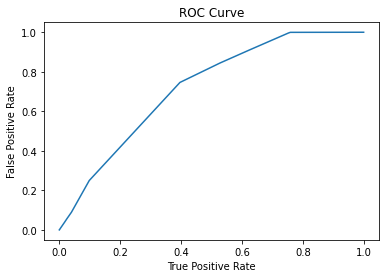

Training set areaUnderROC: 0.71882605923606


In [25]:
#checking if better than random classifier
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
import matplotlib.pyplot as plt
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [26]:
#making predictions on test dataset
predictions = lrModel.transform(test)

In [28]:
#calculating accuracy
accuracy = predictions.filter(predictions.deleted == predictions.prediction).count() / float(predictions.count())

In [29]:
accuracy

0.6245200955781673

In [34]:
#checking which 
lrModel.coefficients

DenseVector([-0.0078, 0.0, -0.0078, -3.4987, 0.0])

In [30]:
########## MAKING ALL PERMUTATIONS OF FEATRUES################################### commenting out since it took too long

In [31]:
"""from itertools import combinations

combinations = sum([list(map(list, combinations(numericCols, i))) for i in range(len(numericCols) + 1)], [])"""

'from itertools import combinations\n\ncombinations = sum([list(map(list, combinations(numericCols, i))) for i in range(len(numericCols) + 1)], [])'

In [32]:
"""combinations = combinations[1:]"""

'combinations = combinations[1:]'

In [33]:
"""accuracies = []
for features in combinations:
    model_df.drop("features")
    assemblerInputs =  features
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages = [assembler]
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(undersampled_df)
    model_df = pipelineModel.transform(undersampled_df)
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'deleted', maxIter=10)
    lrModel = lr.fit(train)
    predictions = lrModel.transform(test)
    accuracies.append(predictions.filter(predictions.deleted == predictions.prediction).count() / float(predictions.count()))
    """

'accuracies = []\nfor features in combinations:\n    model_df.drop("features")\n    assemblerInputs =  features\n    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")\n    stages = [assembler]\n    pipeline = Pipeline(stages = stages)\n    pipelineModel = pipeline.fit(undersampled_df)\n    model_df = pipelineModel.transform(undersampled_df)\n    lr = LogisticRegression(featuresCol = \'features\', labelCol = \'deleted\', maxIter=10)\n    lrModel = lr.fit(train)\n    predictions = lrModel.transform(test)\n    accuracies.append(predictions.filter(predictions.deleted == predictions.prediction).count() / float(predictions.count()))\n    '